<a href="https://colab.research.google.com/github/jakobzhao/data-classification/blob/main/rs-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Remote Sensing Analysis of LST, NDVI, NDBI, and PM2.5 in the Seattle Area

This Google Colab notebook is an interactive **remote sensing analysis tool** built using the [Google Earth Engine (GEE)](https://earthengine.google.com/) platform. It focuses on comparing environmental indices across the **Greater Seattle Area**, including Everett, Seattle, and Bellevue. The analysis supports environmental monitoring, urban planning, and educational demonstrations.

---

## Key Functionalities

The notebook automatically pulls and processes the following Earth observation datasets:

* **Land Surface Temperature (LST)**
  Extracted from **Landsat 8 Collection 2 Level-2** using thermal band calibration formulas.

* **Normalized Difference Vegetation Index (NDVI)**
  Calculated using Landsat 8 bands B5 (NIR) and B4 (Red), indicating vegetation health.

* **Normalized Difference Built-up Index (NDBI)**
  Derived from bands B6 (SWIR1) and B5 (NIR), estimating built-up density or impervious surfaces.

* **PM2.5 Proxy (Atmospheric Aerosols)**
  Approximated using **Sentinel-5P’s absorbing aerosol index** from the *COPERNICUS/S5P/NRTI/L3\_AER\_AI* dataset.


## Study Area and Spatial Scope

* **Area of Interest (AOI)**: A rectangular bounding box over Greater Seattle
  `Coordinates: [-122.45, 47.20, -121.90, 48.10]`

## Data Sources and Properties

| Indicator | Dataset Name                    | Satellite   | Spatial Resolution | Temporal Resolution |
| --------- | ------------------------------- | ----------- | ------------------ | ------------------- |
| LST       | `LANDSAT/LC08/C02/T1_L2`        | Landsat 8   | 30 meters          | Every 16 days       |
| NDVI      | `LANDSAT/LC08/C02/T1_L2`        | Landsat 8   | 30 meters          | Every 16 days       |
| NDBI      | `LANDSAT/LC08/C02/T1_L2`        | Landsat 8   | 30 meters          | Every 16 days       |
| PM2.5     | `COPERNICUS/S5P/NRTI/L3_AER_AI` | Sentinel-5P | \~7 kilometers     | Daily               |

---

## Relevance to this week's reading

What kinds of social conditions (poverty, informal housing, displacement) are made invisible by this kind of mapping?


| Theme                             | Relation to the Code                                                                                                                                                                                                                                                   |
| --------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Data Creation**                 | The notebook *actively creates new layers* (LST, NDVI, NDBI) from raw satellite data. This reflects how data is not simply “found” but *constructed* via model assumptions (e.g., spectral band formulas, cloud filtering).                                            |
| **Resolution Politics**           | Although not explicitly downsampling, the use of **LANDSAT imagery (\~30m resolution)** inherently poses visibility limitations—some urban microstructures (like rooftop gardens or informal housing) are *not visible*, echoing **Bennett et al. (2022)**’s critique. |
| **Algorithmic Choice**            | The user-defined **search, filtering, and thresholding logic** reflects key assumptions: which images count as valid? What date range? What cloud cover threshold? These are *not neutral*.                                                                            |
| **(In)Visibility of Social Life** | Indices like NDVI/NDBI may mask social realities. A lush park may score high NDVI but be inaccessible to marginalized communities. This touches on the **politics of representation**.                                                                                 |
| **Temporal Choices**              | The fallback loop that finds alternate dates if data is missing illustrates the *fragility and constructedness of temporal coverage*—what counts as “recent” or “valid” is codified in the logic.                                                                      |




In [19]:
# Google Colab Script: Remote Sensing Comparative Analysis of LST and NDVI around Seattle

# ▶️ Step 1: Install and initialize
!pip install geemap --quiet  # Install geemap silently
import geemap                # Import geemap for Earth Engine + IPython integration
import ee                    # Import Google Earth Engine Python API
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [21]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-jakobzhao')

In [22]:
# ▶️ Step 2: Define AOI (Area of Interest) - covers Greater Seattle area including Everett, Seattle, Bellevue
aoi = ee.Geometry.Rectangle([-122.45, 47.20, -121.90, 48.10])

In [24]:
# ▶️ Step 3: Automatically search for available images within ±3 months if the target date has no valid data
def search_available_image(get_func, date_start_str, date_end_str, max_shift_months=3):
    fmt = "%Y-%m-%d"
    base_start = datetime.strptime(date_start_str, fmt)
    base_end = datetime.strptime(date_end_str, fmt)

    for i in range(max_shift_months + 1):
        for delta in [-i, i]:
            shift = timedelta(days=30 * delta)
            shifted_start = (base_start + shift).strftime(fmt)
            shifted_end = (base_end + shift).strftime(fmt)
            print(f"⏳ Trying: {shifted_start} to {shifted_end}")
            try:
                img = get_func(shifted_start, shifted_end)
                if img:
                    print(f"✅ Found valid image: {shifted_start} to {shifted_end}")
                    return img
            except Exception as e:
                print(f"⚠️ Error: {e}")
    print("❌ No valid image found")
    return None

In [25]:
# ▶️ Step 4: Define functions to load LST, NDVI, NDBI, and PM2.5 datasets
def get_LST(date_start, date_end):
    def scale_lst(img):
        lst = img.select('ST_B10').multiply(0.00341802).add(149.0).rename('LST')
        return img.addBands(lst)

    collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(date_start, date_end) \
        .filterBounds(aoi) \
        .map(scale_lst) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50))

    return collection.median().select('LST').clip(aoi)


def get_NDVI(date_start, date_end):
    collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(date_start, date_end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
        .map(lambda img: img.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI"))

    return collection.median().select('NDVI').clip(aoi)

def get_NDBI(date_start, date_end):
    collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(date_start, date_end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
        .map(lambda img: img.normalizedDifference(["SR_B6", "SR_B5"]).rename("NDBI"))

    return collection.median().select('NDBI').clip(aoi)

def get_PM25(date_start, date_end):
    collection = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_AER_AI") \
        .filterDate(date_start, date_end) \
        .filterBounds(aoi) \
        .select("absorbing_aerosol_index")

    return collection.mean().rename('PM25').clip(aoi)



In [26]:
# ▶️ Step 5: Load imagery with fallback logic to search ±3 months if no valid data is found in the target period
lst_2014 = search_available_image(get_LST, '2014-07-01', '2014-08-01')
lst_2023 = search_available_image(get_LST, '2023-07-01', '2023-08-01')

ndvi_2014 = search_available_image(get_NDVI, '2014-07-01', '2014-08-01')
ndvi_2023 = search_available_image(get_NDVI, '2023-07-01', '2023-08-01')

ndbi_2014 = search_available_image(get_NDBI, '2014-07-01', '2014-08-01')
ndbi_2023 = search_available_image(get_NDBI, '2023-07-01', '2023-08-01')

pm25_2019 = search_available_image(get_PM25, '2019-07-01', '2019-08-01')
pm25_2023 = search_available_image(get_PM25, '2023-07-01', '2023-08-01')

# ▶️ Step 6: Visualization parameters
lst_vis = {'min': 290, 'max': 320, 'palette': ['blue', 'green', 'yellow', 'red']}
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['white', 'lightgreen', 'green']}
ndbi_vis = {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'orange']}
pm25_vis = {'min': -1, 'max': 3, 'palette': ['blue', 'purple', 'orange', 'red']}

⏳ Trying: 2014-07-01 to 2014-08-01
✅ Found valid image: 2014-07-01 to 2014-08-01
⏳ Trying: 2023-07-01 to 2023-08-01
✅ Found valid image: 2023-07-01 to 2023-08-01
⏳ Trying: 2014-07-01 to 2014-08-01
✅ Found valid image: 2014-07-01 to 2014-08-01
⏳ Trying: 2023-07-01 to 2023-08-01
✅ Found valid image: 2023-07-01 to 2023-08-01
⏳ Trying: 2014-07-01 to 2014-08-01
✅ Found valid image: 2014-07-01 to 2014-08-01
⏳ Trying: 2023-07-01 to 2023-08-01
✅ Found valid image: 2023-07-01 to 2023-08-01
⏳ Trying: 2019-07-01 to 2019-08-01
✅ Found valid image: 2019-07-01 to 2019-08-01
⏳ Trying: 2023-07-01 to 2023-08-01
✅ Found valid image: 2023-07-01 to 2023-08-01


In [27]:
# ▶️ Step 7: Add dropdown menu to switch between indices

def create_split_map(index_type):
    # Create a base map centered over the Daxing region
    Map = geemap.Map(center=[47.60, -122.33], zoom=10)

    # Load and visualize different layers depending on the selected index
    if index_type == 'NDVI':
        left = geemap.ee_tile_layer(ndvi_2014.visualize(**ndvi_vis), {}, 'NDVI 2014')
        right = geemap.ee_tile_layer(ndvi_2023.visualize(**ndvi_vis), {}, 'NDVI 2023')
    elif index_type == 'NDBI':
        left = geemap.ee_tile_layer(ndbi_2014.visualize(**ndbi_vis), {}, 'NDBI 2014')
        right = geemap.ee_tile_layer(ndbi_2023.visualize(**ndbi_vis), {}, 'NDBI 2023')
    elif index_type == 'LST':
        left = geemap.ee_tile_layer(lst_2014.visualize(**lst_vis), {}, 'LST 2014')
        right = geemap.ee_tile_layer(lst_2023.visualize(**lst_vis), {}, 'LST 2023')
    elif index_type == 'PM2.5':
        left = geemap.ee_tile_layer(pm25_2019.visualize(**pm25_vis), {}, 'PM2.5 2019')
        right = geemap.ee_tile_layer(pm25_2023.visualize(**pm25_vis), {}, 'PM2.5 2023')
    else:
        print("❌ Invalid option")
        return

    # Display the split map view (drag to compare left/right)
    Map.split_map(left, right)
    display(Map)

# Create a dropdown widget to choose between indices
widgets.interact(create_split_map, index_type=widgets.Dropdown(
    options=['NDVI', 'NDBI', 'LST', 'PM2.5'],
    value='NDVI',
    description='Select Index:'
))


interactive(children=(Dropdown(description='Select Index:', options=('NDVI', 'NDBI', 'LST', 'PM2.5'), value='N…

<function __main__.create_split_map(index_type)>

In [28]:
# Plot overlapping histograms of the same index from two years for visual comparison
def plot_combined_histogram(image1, image2, band_name, year1, year2):
    # Reduce region to extract pixel values as a list for both years
    values1 = ee.List(image1.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=aoi,
        scale=30,
        maxPixels=1e8
    ).get(band_name)).getInfo()

    values2 = ee.List(image2.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=aoi,
        scale=30,
        maxPixels=1e8
    ).get(band_name)).getInfo()

    # Plot histograms on the same figure
    plt.figure(figsize=(7, 5))
    plt.hist(values1, bins=50, alpha=0.6, color='skyblue', label=f'{year1}')
    plt.hist(values2, bins=50, alpha=0.6, color='orange', label=f'{year2}')
    plt.title(f"{band_name} Histogram: {year1} vs {year2}")
    plt.xlabel(band_name)
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage (manual call or via dropdown):
# plot_combined_histogram(lst_2014, lst_2023, 'LST', 2014, 2023)

# Function to trigger the histogram based on dropdown selection
def display_histogram(index_type):
    if index_type == 'NDVI':
        plot_combined_histogram(ndvi_2014, ndvi_2023, 'NDVI', 2014, 2023)
    elif index_type == 'NDBI':
        plot_combined_histogram(ndbi_2014, ndbi_2023, 'NDBI', 2014, 2023)
    elif index_type == 'LST':
        plot_combined_histogram(lst_2014, lst_2023, 'LST', 2014, 2023)
    elif index_type == 'PM2.5':
        plot_combined_histogram(pm25_2019, pm25_2023, 'PM25', 2019, 2023)

# Create dropdown menu to choose which index to visualize
widgets.interact(display_histogram, index_type=widgets.Dropdown(
    options=['NDVI', 'NDBI', 'LST', 'PM2.5'],
    value='NDVI',
    description='Index Histogram:'
))


interactive(children=(Dropdown(description='Index Histogram:', options=('NDVI', 'NDBI', 'LST', 'PM2.5'), value…

<function __main__.display_histogram(index_type)>

In [29]:
# ▶️ Step 8: Output summary statistics table (mean value comparison)

# Function to calculate the mean of a specific band within the AOI
def get_band_mean(image, band_name):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e8
    )
    return stats.get(band_name).getInfo()

# Function to print the summary statistics table comparing two years
def print_stat_table():
    data = []
    data.append(["NDVI", round(get_band_mean(ndvi_2014, 'NDVI'), 4), round(get_band_mean(ndvi_2023, 'NDVI'), 4)])
    data.append(["NDBI", round(get_band_mean(ndbi_2014, 'NDBI'), 4), round(get_band_mean(ndbi_2023, 'NDBI'), 4)])
    data.append(["LST", round(get_band_mean(lst_2014, 'LST'), 2), round(get_band_mean(lst_2023, 'LST'), 2)])
    data.append(["PM2.5", round(get_band_mean(pm25_2019, 'PM25'), 2), round(get_band_mean(pm25_2023, 'PM25'), 2)])

    print("\n📊 Summary of Mean Values:")
    print("| Index  | Year1 | Year2 | ΔValue |")
    print("|--------|--------|--------|--------|")
    for row in data:
        diff = round(row[2] - row[1], 4)
        print(f"| {row[0]:<6} | {row[1]:<6} | {row[2]:<6} | {diff:<+6} |")

# Manual call example:
# print_stat_table()

# Optional: Add a button to trigger the statistics table display
show_stats_btn = widgets.Button(description="📈 Show Summary Statistics Table")
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        print_stat_table()

show_stats_btn.on_click(on_button_click)
display(show_stats_btn, output)

Button(description='📈 Show Summary Statistics Table', style=ButtonStyle())

Output()

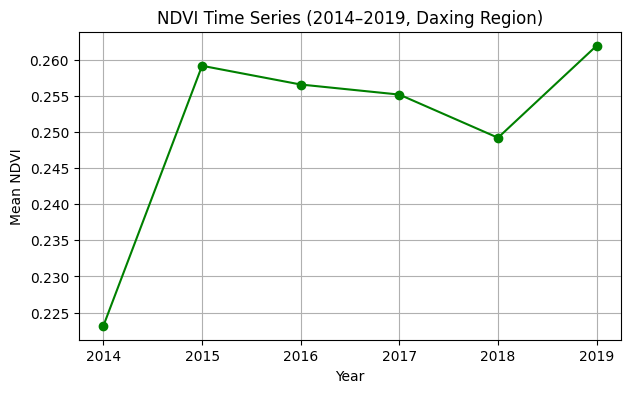

In [30]:
# ▶️ Step 8: Output summary statistics table (mean value comparison)

import time  # Ensure this is imported at the top
import pandas as pd

# ▶️ Step 9: Generate NDVI time series analysis (2014–2019)

# Function to compute NDVI mean value for a given year (using summer imagery)
def get_yearly_ndvi(year):
    start = ee.Date.fromYMD(year, 6, 1)
    end = start.advance(2, 'month')  # Analyze June–August
    collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
        .map(lambda img: img.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI"))

    ndvi_image = collection.median().select('NDVI')
    return get_band_mean(ndvi_image, 'NDVI')

# Create list of years and extract NDVI mean value for each year
years = list(range(2014, 2020))
ndvi_values = []
for y in years:
    val = get_yearly_ndvi(y)
    ndvi_values.append(val)

# Plot the NDVI time series
plt.figure(figsize=(7, 4))
plt.plot(years, ndvi_values, marker='o', linestyle='-', color='green')
plt.title("NDVI Time Series (2014–2019, Greater Seattle Region)")
plt.xlabel("Year")
plt.ylabel("Mean NDVI")
plt.grid(True)
plt.show()


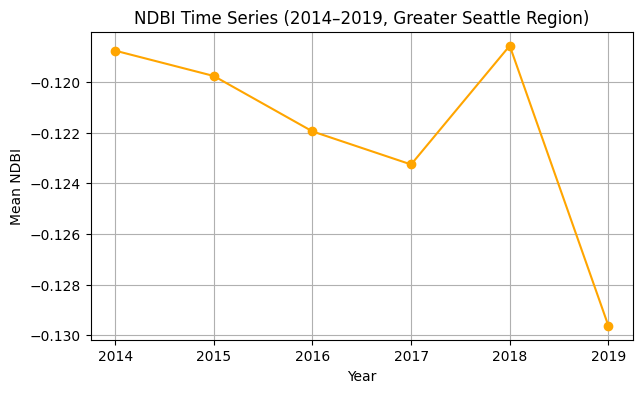

In [32]:
# ▶️ Step 10: Generate NDBI time series analysis (2014–2019)

# Function to compute NDBI mean value for a given year (summer, low cloud cover)
def get_yearly_ndbi(year):
    start = ee.Date.fromYMD(year, 6, 1)
    end = start.advance(2, 'month')  # Analyze June–August
    collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
        .map(lambda img: img.normalizedDifference(["SR_B6", "SR_B5"]).rename("NDBI"))

    ndbi_image = collection.median().select('NDBI')
    return get_band_mean(ndbi_image, 'NDBI')

# Generate NDBI values for each year in the list
ndbi_values = []
for y in years:
    val = get_yearly_ndbi(y)
    ndbi_values.append(val)

# Plot the NDBI time series
plt.figure(figsize=(7, 4))
plt.plot(years, ndbi_values, marker='o', linestyle='-', color='orange')
plt.title("NDBI Time Series (2014–2019, Greater Seattle Region)")
plt.xlabel("Year")
plt.ylabel("Mean NDBI")
plt.grid(True)
plt.show()


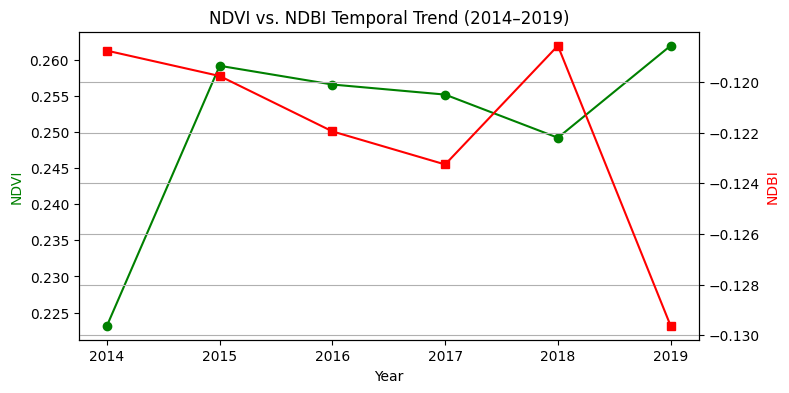

In [33]:
# Plot NDVI and NDBI trends together using dual y-axes (2014–2019)

fig, ax1 = plt.subplots(figsize=(8, 4))  # Create main figure and first y-axis
ax2 = ax1.twinx()  # Create second y-axis sharing the same x-axis

# Plot NDVI on the left axis (green)
ax1.plot(years, ndvi_values, 'g-o', label='NDVI')
ax1.set_ylabel('NDVI', color='green')

# Plot NDBI on the right axis (red)
ax2.plot(years, ndbi_values, 'r-s', label='NDBI')
ax2.set_ylabel('NDBI', color='red')

ax1.set_xlabel('Year')
plt.title("NDVI vs. NDBI Temporal Trend (2014–2019)")
plt.grid(True)
plt.show()
